# Tutorial for get context specific TRN embedding

For each 1kb genomic region, ChromBERT generates a transcriptional regulatory network (TRN) embedding with a shape of (6391, 768). This embedding captures the 6391 cistromes within the genomic context, which include transcription factors, histone modifications, and chromatin accessibility. Collectively, these elements are referred to as "transcription regulators" throughout this tutorial. Notably, each regulator may be associated with multiple cistromes. Users can extract embeddings at different levels (cistrome or regulator) by applying varying levels of summarization.

Workflow Overview:
- Prepare the genomic loci of interest.  
- Load the ChromBERT model.  
- Generate embeddings.  

Let’s dive in!

In [1]:
import os 
import torch 
import chrombert 
from tqdm import tqdm
import numpy as np
import pandas as pd 
from umap import UMAP

import seaborn as sns
from matplotlib import pyplot as plt

from torchinfo import summary

basedir = os.path.expanduser("~/.cache/chrombert/data")


/home/yangdongxu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Prepare dataset
For demonstration purposes, we will use a simple toy dataset. Sample data can be found in the `~/.cache/chrombert/data` folder, but you are welcome to replace it with your own dataset. For detailed information about the dataset, please refer to the [quick tour](https://chrombert.readthedocs.io/en/latest/quick_tour.html).  


In [2]:
supervised_file = os.path.join(basedir, "demo","general_classification", "train.csv")
! head {supervised_file}

chrom,start,end,build_region_index,label
chr1,39514000,39515000,34032,1.0
chr9,77647000,77648000,2009188,1.0
chr7,76267000,76268000,1800242,1.0
chr16,154000,155000,690707,1.0
chr11,45252000,45253000,320175,0.0
chr19,58538000,58539000,918112,0.0
chr14,90903000,90904000,613068,0.0
chr14,41607000,41608000,575793,1.0
chr19,41883000,41884000,904333,1.0


In [3]:
# Create a configuration class for dataset and dataloader. 
dc = chrombert.get_preset_dataset_config("general", basedir=basedir, supervised_file = os.path.join(basedir, "demo","general_classification", "train.csv"))
dc

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json


DatasetConfig({'hdf5_file': '/home/yangdongxu/.cache/chrombert/data/hg38_6k_1kb.hdf5', 'supervised_file': '/home/yangdongxu/.cache/chrombert/data/demo/general_classification/train.csv', 'kind': 'GeneralDataset', 'meta_file': '/home/yangdongxu/.cache/chrombert/data/config/hg38_6k_meta.json', 'ignore': False, 'ignore_object': None, 'batch_size': 8, 'num_workers': 20, 'shuffle': False, 'pin_memory': True, 'perturbation': False, 'perturbation_object': None, 'perturbation_value': 0, 'prompt_kind': None, 'prompt_regulator': None, 'prompt_regulator_cache_file': None, 'prompt_celltype': None, 'prompt_celltype_cache_file': None, 'prompt_regulator_cache_pin_memory': False, 'prompt_regulator_cache_limit': 3, 'fasta_file': None, 'flank_window': 0})

In [4]:
# Instantiate the dataset and dataloader 
ds = dc.init_dataset()
dl = dc.init_dataloader(batch_size = 2)
ds[1]

{'input_ids': tensor([9, 7, 6,  ..., 5, 5, 5], dtype=torch.int8),
 'position_ids': tensor([   1,    2,    3,  ..., 6389, 6390, 6391]),
 'region': tensor([       9, 77647000, 77648000], dtype=torch.int32),
 'build_region_index': 2009188,
 'label': 1.0}

## Load ChromBERT model
You can either use the pre-trained model directly or fine-tune the model with your own data. 

To load fine-tuned models, you can use the following code:  
```python
ft_ckpt = None # fill your checkpoint path here
mc = chrombert.get_preset_model_config("general", basedir=basedir, finetune_ckpt=ft_ckpt, dropout = 0)
model = mc.init_model().cuda().bfloat16()
model
```

Below, we demonstrate how to use the pre-trained model directly.   

In [5]:
mc = chrombert.ChromBERTConfig(
    genome = "hg38",
    ckpt =os.path.join(basedir, "checkpoint", "hg38_6k_1kb_pretrain.ckpt"),
    dropout = 0
)
model = mc.init_model().cuda().bfloat16()
summary(model, depth = 2)

use organisim hg38; max sequence length is 6391


Layer (type:depth-idx)                             Param #
ChromBERT                                          --
├─BERTEmbedding: 1-1                               --
│    └─TokenEmbedding: 2-1                         7,680
│    └─PositionalEmbedding: 2-2                    4,909,056
│    └─Dropout: 2-3                                --
├─ModuleList: 1-2                                  --
│    └─EncoderTransformerBlock: 2-4                6,497,280
│    └─EncoderTransformerBlock: 2-5                6,497,280
│    └─EncoderTransformerBlock: 2-6                6,497,280
│    └─EncoderTransformerBlock: 2-7                6,497,280
│    └─EncoderTransformerBlock: 2-8                6,497,280
│    └─EncoderTransformerBlock: 2-9                6,497,280
│    └─EncoderTransformerBlock: 2-10               6,497,280
│    └─EncoderTransformerBlock: 2-11               6,497,280
Total params: 56,894,976
Trainable params: 56,894,976
Non-trainable params: 0

In [6]:
for batch in dl:
    emb = model(batch["input_ids"].cuda(), batch["position_ids"].cuda())
    break
emb.shape # TRN embeddings for two 1-kb regions. 

torch.Size([2, 6391, 768])

## Extracting embeddings with the embedding manager  
The code above retrieves TRN embedding for the specified locus.   
To simplify the process of obtaining embeddings for each cistrome or regulator, we provide a dedicated class, accessible via model.get_embedding_manager.   
For each batch, you need to perform a forward pass and then extract embeddings at the cistrome, regulator, and locus levels.

In [7]:
# This process also works seamlessly with fine-tuned models.
model_emb = model.get_embedding_manager(
    mtx_mask = os.path.join(basedir, "config", "hg38_6k_mask_matrix.tsv")
) 
summary(model_emb)

Layer (type:depth-idx)                                  Param #
ChromBERTEmbedding                                      --
├─ChromBERT: 1-1                                        --
│    └─BERTEmbedding: 2-1                               --
│    │    └─TokenEmbedding: 3-1                         7,680
│    │    └─PositionalEmbedding: 3-2                    4,909,056
│    │    └─Dropout: 3-3                                --
│    └─ModuleList: 2-2                                  --
│    │    └─EncoderTransformerBlock: 3-4                6,497,280
│    │    └─EncoderTransformerBlock: 3-5                6,497,280
│    │    └─EncoderTransformerBlock: 3-6                6,497,280
│    │    └─EncoderTransformerBlock: 3-7                6,497,280
│    │    └─EncoderTransformerBlock: 3-8                6,497,280
│    │    └─EncoderTransformerBlock: 3-9                6,497,280
│    │    └─EncoderTransformerBlock: 3-10               6,497,280
│    │    └─EncoderTransformerBlock: 3-11          

In [8]:
for batch in dl:
    for k, v in batch.items():
        if isinstance(v, torch.Tensor):
            batch[k] = v.cuda()
    emb = model_emb(batch)
    break
# by default, it returns all regulator embedding
emb.shape 

torch.Size([2, 1073, 768])

In [9]:
emb = model_emb.get_cistrome_embedding("GSM623516".lower())
emb.shape, emb

(torch.Size([2, 768]),
 tensor([[ 0.3359, -1.6172,  5.3750,  ...,  1.4922, -3.0781,  2.7969],
         [-0.9023, -1.4297,  4.0625,  ...,  1.3750, -3.7188,  3.4844]],
        device='cuda:0', dtype=torch.bfloat16))

In [10]:
emb = model_emb.get_regulator_embedding("ctcf".lower())
emb.shape, emb

(torch.Size([2, 768]),
 tensor([[ 0.0496, -0.7969,  4.4375,  ..., -2.0156, -0.9922,  0.7383],
         [-0.5781, -1.4766,  2.6250,  ..., -1.3828, -0.3848,  0.8906]],
        device='cuda:0', dtype=torch.bfloat16))

In [11]:
emb = model_emb.get_region_embedding()
emb.shape, emb

(torch.Size([2, 768]),
 tensor([[ 0.6992, -0.1250,  2.3906,  ..., -0.8672, -0.4238,  0.7617],
         [-0.2305, -0.6602,  0.9375,  ..., -0.5391,  0.2080,  0.9844]],
        device='cuda:0', dtype=torch.bfloat16))

## Example: mean pooled TRN embedding (embeddings for the locus)
ChromBERT represents context-specific TRNs and is effective for identifying similarities between cis-elements, such as transcription factor (TF) binding sites. In this example, we will obtain the mean pooled TRN embedding and demonstrate how ChromBERT can capture the distinct features of CTCF binding sites compared to other sites.

Note: mean pooled TRN embedding derived directly from the pretrained model may not reflect cell type-specific features. To obtain cell type-specific region embeddings, consider fine-tuning the model with your own data. Please refer to the fine-tuning tutorial for more details.


In [12]:
# For the first step, we prepare the dataset table.
from chrombert.scripts.chrombert_make_dataset import get_overlap

df_supervised = get_overlap(
    supervised = os.path.join(basedir, "demo", "embedding","CTCF_ENCFF664UGR.bed"), # a narrowPeak file
    regions = os.path.join(basedir, "config", "hg38_6k_1kb_region.bed"),
    no_filter = True,
).assign(label = lambda df: df["label"] > 0 )
df_supervised

,chrom,start,end,build_region_index,label
0,chr1,10000,11000,0,False
1,chr1,16000,17000,1,False
2,chr1,17000,18000,2,False
3,chr1,29000,30000,3,False
4,chr1,30000,31000,4,False
...,...,...,...,...,...
2137889,chrY,26671000,26672000,2137889,False
2137890,chrY,56674000,56675000,2137890,False
2137891,chrY,56678000,56679000,2137891,False
2137892,chrY,56684000,56685000,2137892,False


In [13]:
# sample down for quick demo
df_sample = df_supervised.query("chrom == 'chr1' ").groupby("label").sample(500, random_state = 1024).reset_index(drop = True)
df_sample.to_csv("supervised_sample.csv", index = False)

df_sample

,chrom,start,end,build_region_index,label
0,chr1,97674000,97675000,81042,False
1,chr1,64197000,64198000,55110,False
2,chr1,77152000,77153000,64764,False
3,chr1,244174000,244175000,180253,False
4,chr1,163181000,163182000,113123,False
...,...,...,...,...,...
995,chr1,16082000,16083000,13121,True
996,chr1,210950000,210951000,152080,True
997,chr1,1165000,1166000,451,True
998,chr1,53278000,53279000,45687,True


In [14]:
# create dataset and dataloader. 
dc = chrombert.get_preset_dataset_config("general", basedir=basedir, supervised_file = "supervised_sample.csv")
dl = dc.init_dataloader(batch_size = 2)
ds = dc.init_dataset()
ds[0]

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json


{'input_ids': tensor([6, 5, 5,  ..., 6, 5, 5], dtype=torch.int8),
 'position_ids': tensor([   1,    2,    3,  ..., 6389, 6390, 6391]),
 'region': tensor([       1, 97674000, 97675000], dtype=torch.int32),
 'build_region_index': 81042,
 'label': False}

In [15]:
emb_regions = []
labels = []
# collect mean pooled TRN embeddings
with torch.no_grad():
    for batch in tqdm(dl):
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.cuda()
        emb = model_emb(batch)
        emb_regions.append(model_emb.get_region_embedding())
        labels.extend(batch["label"].tolist())
labels = np.array(labels)

mtx_emb_regions = torch.cat(emb_regions, dim = 0).detach().float().cpu().numpy()
mtx_emb_regions.shape

100%|██████████| 500/500 [00:19<00:00, 25.25it/s]


(1000, 768)

/home/yangdongxu/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


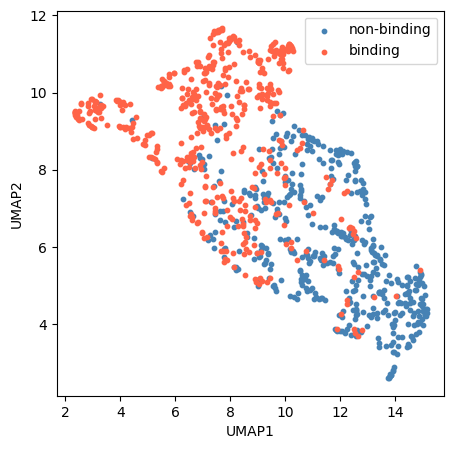

In [16]:
# A UMAP scatter plot demonstrates that ChromBERT's mean-pooled TRN embeddings effectively distinguish between binding and non-binding regions for CTCF.
mtx_umap = UMAP(n_components = 2, random_state = 1024).fit_transform(mtx_emb_regions)

fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(mtx_umap[~labels,0], mtx_umap[~labels,1], c = "steelblue", s = 10, label = "non-binding")
ax.scatter(mtx_umap[labels,0], mtx_umap[labels,1], c = "tomato", s = 10, label = "binding")
ax.legend()
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
plt.show()

In [17]:
!rm supervised_sample.csv # clean environment 

## Example: regulator embedding
Below is an example demonstrating the use of ChromBERT's regulator embedding.

At certain loci, RNF2 exhibits similarity with PCGF2, a canonical component of the PRC complex. Conversely, at other loci, RNF2 shows a higher similarity to EP300 and MYC, which are associated with enhancer activity.

We will start with a processed demo dataset.


In [18]:
supervised_file = os.path.join(basedir, "demo", "embedding", "specific_rnf2_loc_region.csv")
!head {supervised_file}

chrom,start,end,build_region_index
chr1,7770000,7771000,6075
chr1,160083000,160084000,110373
chr1,177633000,177634000,124855
chr1,235083000,235084000,172824
chr1,149608000,149609000,101527
chr1,200081000,200082000,142366
chr1,10651000,10652000,8725
chr1,112854000,112855000,91931
chr1,39770000,39771000,34259


In [19]:
dc = chrombert.get_preset_dataset_config("general", basedir=basedir, supervised_file = supervised_file)
dl = dc.init_dataloader(batch_size = 2)
ds = dc.init_dataset()
ds[0]

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json
Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.
Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.


{'input_ids': tensor([8, 6, 8,  ..., 6, 6, 6], dtype=torch.int8),
 'position_ids': tensor([   1,    2,    3,  ..., 6389, 6390, 6391]),
 'region': tensor([      1, 7770000, 7771000], dtype=torch.int32),
 'build_region_index': 6075}

In [20]:
emb_regions = []
list_factors = ["MYC", "EP300", "PCGF2"]
dict_similarities = {i:[] for i in list_factors}

# Collect regulator embeddings and compute their cosine similarity.

with torch.no_grad():
    for batch in tqdm(dl):
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.cuda()
        model_emb(batch)
        emb_rnf2 = model_emb.get_regulator_embedding("rnf2")
        for factor in list_factors:
            emb = model_emb.get_regulator_embedding(factor)
            dict_similarities[factor].append(torch.nn.functional.cosine_similarity(emb_rnf2, emb).float().cpu().numpy())
for factor in dict_similarities:
    dict_similarities[factor] = np.concatenate(dict_similarities[factor])
df_sim = pd.DataFrame(dict_similarities)
df_sim

100%|██████████| 210/210 [00:10<00:00, 19.42it/s]


,MYC,EP300,PCGF2
0,0.656250,0.761719,0.480469
1,0.648438,0.734375,0.464844
2,0.820312,0.796875,0.546875
3,0.742188,0.777344,0.507812
4,0.847656,0.882812,0.570312
...,...,...,...
415,0.406250,0.417969,0.707031
416,0.435547,0.412109,0.738281
417,0.431641,0.406250,0.714844
418,0.449219,0.419922,0.750000


Text(0.5, 1.2, 'Cosine Similarity of RNF2 with Other Regulators')

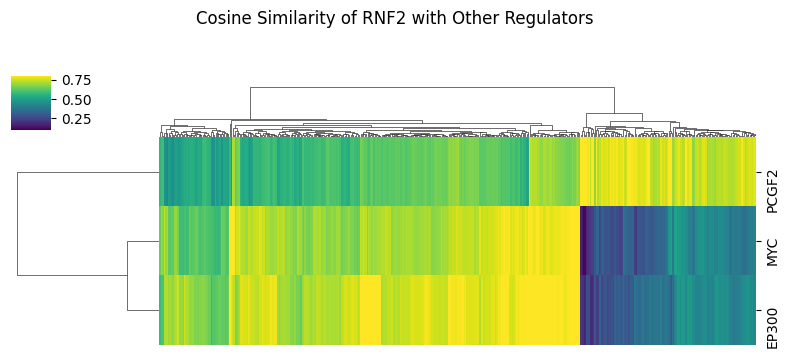

In [21]:
# higher cosine similarity generally indicates stronger relationship
g = sns.clustermap(df_sim.T, figsize=(8,3), xticklabels = False, cmap = "viridis", vmin = 0.1, vmax = 0.8)
g.figure.suptitle("Cosine Similarity of RNF2 with Other Regulators",y=1.2)

## The end
That’s almost everything!  

For models fine-tuned for gene expression prediction or similar tasks, the process involves pooling multiple regions to generate the final embedding. We provide unified functions to facilitate this, but for detailed instructions, please refer to the corresponding tutorial file.   
